In [2]:
#! git clone https://github.com/pytorch/vision
#! pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI
#install cython first with python -m pip install --upgrade cython
#! pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html --user
#! pip install pandas
#! pip install matplotlib
#! pip install tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import numpy as np
from PIL import Image
import torch
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
torch.cuda.is_available()
np.random.seed(10)

In [3]:
! nvidia-smi

Fri Nov  5 21:53:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 30%   43C    P8    21W / 250W |  10766MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
| 30%   

In [4]:
annotation = np.genfromtxt('annotations_new.csv', delimiter=',', dtype=str)[1:]
annotation

array([['0', 'houston_1759099178859753618_20180416.jpg', '608', ...,
        '299', '111', '334'],
       ['1', 'houston_1547624367717008092_20170629.jpg', '608', ..., '8',
        '387', '45'],
       ['2', 'houston_1725195998627592009_20180301.jpg', '608', ...,
        '91', '99', '125'],
       ...,
       ['1002', 'la_2017_1629395987017498498_20171020.jpg', '608', ...,
        '189', '385', '282'],
       ['1003', 'la_2017_1629395987017498498_20171020.jpg', '608', ...,
        '433', '405', '446'],
       ['1004', 'london_1942237526668548070_20181225.jpg', '608', ...,
        '523', '493', '595']], dtype='<U42')

In [5]:
np.where(annotation[:, 8].astype(int) - annotation[:, 6].astype(int) == 0)[0]

array([12854])

In [6]:
annotation = np.delete(annotation, np.where(annotation[:, 8].astype(int) - annotation[:, 6].astype(int) == 0)[0], axis=0)

In [7]:
np.where(annotation[:, 8].astype(int) - annotation[:, 6].astype(int) == 0)[0]

array([], dtype=int64)

In [8]:
im = Image.open("train/charlotte_1490308291891304123_20170411.jpg").convert("RGB")
im.size

(540, 675)

In [9]:
unique, counts = np.unique(annotation[:, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['Adidas' '9869']
 ['Nike' '12683']
 ['Puma' '1299']
 ['The North Face' '921']
 ['Under Armour' '1660']
 ['n-' '1']]


In [10]:
print(len(annotation))
annotation = annotation[np.isin(annotation[:, 4], ['Adidas', 'Nike', 'Puma', 'The North Face', 'Under Armour'])]
print(len(annotation))

26433
26432


In [11]:
unique, counts = np.unique(annotation[:5000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['Adidas' '1804']
 ['Nike' '2521']
 ['Puma' '200']
 ['The North Face' '129']
 ['Under Armour' '346']]


In [12]:
annotation[:, 4][np.where(annotation[:, 4] == 'Adidas')] = '1'
annotation[:, 4][np.where(annotation[:, 4] == 'Nike')] = '2'
annotation[:, 4][np.where(annotation[:, 4] == 'Puma')] = '3'
annotation[:, 4][np.where(annotation[:, 4] == 'The North Face')] = '4'
annotation[:, 4][np.where(annotation[:, 4] == 'Under Armour')] = '5'

In [13]:
np.random.shuffle(annotation)

In [14]:
unique, counts = np.unique(annotation[:20000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['1' '7522']
 ['2' '9536']
 ['3' '985']
 ['4' '705']
 ['5' '1252']]


In [15]:
unique, counts = np.unique(annotation[20000:30000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['1' '2347']
 ['2' '3147']
 ['3' '314']
 ['4' '216']
 ['5' '408']]


In [16]:
#annotation[:, 5] = annotation[:, 5].astype(int) / annotation[:, 2].astype(int)
#annotation[:, 7] = annotation[:, 7].astype(int) / annotation[:, 2].astype(int)
#annotation[:, 6] = annotation[:, 6].astype(int) / annotation[:, 3].astype(int)
#annotation[:, 8] = annotation[:, 8].astype(int) / annotation[:, 3].astype(int)


In [17]:
print(len(annotation))

26432


In [18]:
annotation[np.where(annotation[:, 1] == 'phoenix_1711051179834496469_20180209.jpg')[0]][:, 5:9].astype(np.float64)

array([[444., 368., 498., 402.]])

In [19]:
class DLCVDataset(torch.utils.data.Dataset):
    def __init__(self, annotation, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = annotation[:, 1]
        self.annotation = annotation

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join("train", self.imgs[idx])
        num_objs = len(np.where(annotation[:, 1] == self.imgs[idx])[0])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((608,608))
        
        boxes = annotation[np.where(annotation[:, 1] == self.imgs[idx])[0]][:, 5:9].astype(int).tolist()
            
        boxes = torch.as_tensor(boxes, dtype=torch.float64)
        
        labels = annotation[np.where(annotation[:, 1] == self.imgs[idx])[0]][:, 4].astype(int).tolist()

        labels = torch.as_tensor(labels, dtype=torch.int64)


        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

    def __len__(self):
        return len(self.imgs)

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [22]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')


# our dataset has two classes only - background and person
num_classes = 6
# use our dataset and defined transformations
dataset = DLCVDataset(annotation=annotation, transforms=get_transform(train=True))
dataset_test = DLCVDataset(annotation=annotation, transforms=get_transform(train=False))                                                                                                                                                                                                                                                                                                                                                           

In [23]:
#split the dataset in train and test set

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:21000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[21000:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [24]:
len(data_loader_test)

5432

In [25]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.95, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device)

print("That's it!")

/home/3040302/.conda/envs/vision2021/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/10500]  eta: 3:14:03  lr: 0.000010  loss: 2.3699 (2.3699)  loss_classifier: 1.8144 (1.8144)  loss_box_reg: 0.0391 (0.0391)  loss_objectness: 0.4908 (0.4908)  loss_rpn_box_reg: 0.0256 (0.0256)  time: 1.1089  data: 0.4698  max mem: 0
Epoch: [0]  [ 1000/10500]  eta: 0:42:01  lr: 0.005000  loss: 0.1162 (0.2533)  loss_classifier: 0.0525 (0.1258)  loss_box_reg: 0.0581 (0.0983)  loss_objectness: 0.0036 (0.0240)  loss_rpn_box_reg: 0.0037 (0.0053)  time: 0.2743  data: 0.0098  max mem: 0
Epoch: [0]  [ 2000/10500]  eta: 0:37:54  lr: 0.005000  loss: 0.1193 (0.2107)  loss_classifier: 0.0495 (0.0974)  loss_box_reg: 0.0682 (0.0907)  loss_objectness: 0.0032 (0.0175)  loss_rpn_box_reg: 0.0019 (0.0051)  time: 0.2829  data: 0.0096  max mem: 0
Epoch: [0]  [ 3000/10500]  eta: 0:34:22  lr: 0.005000  loss: 0.0942 (0.1966)  loss_classifier: 0.0332 (0.0873)  loss_box_reg: 0.0572 (0.0892)  loss_objectness: 0.0040 (0.0149)  loss_rpn_box_reg: 0.0025 (0.0052)  time: 0.2843  data: 0.0089  max mem

Test:  [3900/5432]  eta: 0:02:04  model_time: 0.0631 (0.0660)  evaluator_time: 0.0075 (0.0080)  time: 0.0780  data: 0.0047  max mem: 0
Test:  [4000/5432]  eta: 0:01:56  model_time: 0.0646 (0.0660)  evaluator_time: 0.0075 (0.0080)  time: 0.0791  data: 0.0043  max mem: 0
Test:  [4100/5432]  eta: 0:01:48  model_time: 0.0678 (0.0660)  evaluator_time: 0.0075 (0.0080)  time: 0.0820  data: 0.0047  max mem: 0
Test:  [4200/5432]  eta: 0:01:40  model_time: 0.0667 (0.0660)  evaluator_time: 0.0075 (0.0080)  time: 0.0815  data: 0.0046  max mem: 0
Test:  [4300/5432]  eta: 0:01:31  model_time: 0.0687 (0.0660)  evaluator_time: 0.0076 (0.0080)  time: 0.0820  data: 0.0044  max mem: 0
Test:  [4400/5432]  eta: 0:01:23  model_time: 0.0680 (0.0660)  evaluator_time: 0.0076 (0.0080)  time: 0.0827  data: 0.0047  max mem: 0
Test:  [4500/5432]  eta: 0:01:15  model_time: 0.0646 (0.0660)  evaluator_time: 0.0075 (0.0080)  time: 0.0791  data: 0.0047  max mem: 0
Test:  [4600/5432]  eta: 0:01:07  model_time: 0.0636 (0

Test:  [1300/5432]  eta: 0:04:48  model_time: 0.0559 (0.0554)  evaluator_time: 0.0068 (0.0078)  time: 0.0683  data: 0.0033  max mem: 0
Test:  [1400/5432]  eta: 0:04:41  model_time: 0.0565 (0.0553)  evaluator_time: 0.0070 (0.0077)  time: 0.0691  data: 0.0034  max mem: 0
Test:  [1500/5432]  eta: 0:04:34  model_time: 0.0568 (0.0553)  evaluator_time: 0.0071 (0.0077)  time: 0.0691  data: 0.0033  max mem: 0
Test:  [1600/5432]  eta: 0:04:27  model_time: 0.0562 (0.0553)  evaluator_time: 0.0071 (0.0077)  time: 0.0684  data: 0.0033  max mem: 0
Test:  [1700/5432]  eta: 0:04:19  model_time: 0.0568 (0.0553)  evaluator_time: 0.0066 (0.0076)  time: 0.0685  data: 0.0033  max mem: 0
Test:  [1800/5432]  eta: 0:04:12  model_time: 0.0567 (0.0553)  evaluator_time: 0.0067 (0.0076)  time: 0.0698  data: 0.0034  max mem: 0
Test:  [1900/5432]  eta: 0:04:05  model_time: 0.0569 (0.0553)  evaluator_time: 0.0069 (0.0076)  time: 0.0695  data: 0.0034  max mem: 0
Test:  [2000/5432]  eta: 0:03:59  model_time: 0.0567 (0

Epoch: [2]  [ 6000/10500]  eta: 0:20:40  lr: 0.005000  loss: 0.1025 (0.1545)  loss_classifier: 0.0344 (0.0585)  loss_box_reg: 0.0725 (0.0811)  loss_objectness: 0.0035 (0.0099)  loss_rpn_box_reg: 0.0023 (0.0051)  time: 0.2768  data: 0.0091  max mem: 0
Epoch: [2]  [ 7000/10500]  eta: 0:16:06  lr: 0.005000  loss: 0.1560 (0.1547)  loss_classifier: 0.0521 (0.0587)  loss_box_reg: 0.0756 (0.0813)  loss_objectness: 0.0088 (0.0098)  loss_rpn_box_reg: 0.0033 (0.0049)  time: 0.2594  data: 0.0092  max mem: 0
Epoch: [2]  [ 8000/10500]  eta: 0:11:29  lr: 0.005000  loss: 0.0866 (0.1546)  loss_classifier: 0.0397 (0.0588)  loss_box_reg: 0.0426 (0.0811)  loss_objectness: 0.0019 (0.0097)  loss_rpn_box_reg: 0.0015 (0.0049)  time: 0.2750  data: 0.0089  max mem: 0
Epoch: [2]  [ 9000/10500]  eta: 0:06:53  lr: 0.005000  loss: 0.1148 (0.1548)  loss_classifier: 0.0430 (0.0589)  loss_box_reg: 0.0678 (0.0813)  loss_objectness: 0.0011 (0.0096)  loss_rpn_box_reg: 0.0017 (0.0049)  time: 0.2869  data: 0.0088  max mem

Test:  [5000/5432]  eta: 0:00:29  model_time: 0.0555 (0.0556)  evaluator_time: 0.0056 (0.0063)  time: 0.0673  data: 0.0034  max mem: 0
Test:  [5100/5432]  eta: 0:00:22  model_time: 0.0558 (0.0556)  evaluator_time: 0.0055 (0.0063)  time: 0.0676  data: 0.0034  max mem: 0
Test:  [5200/5432]  eta: 0:00:15  model_time: 0.0555 (0.0556)  evaluator_time: 0.0057 (0.0063)  time: 0.0683  data: 0.0035  max mem: 0
Test:  [5300/5432]  eta: 0:00:09  model_time: 0.0570 (0.0556)  evaluator_time: 0.0059 (0.0063)  time: 0.0683  data: 0.0034  max mem: 0
Test:  [5400/5432]  eta: 0:00:02  model_time: 0.0569 (0.0556)  evaluator_time: 0.0060 (0.0063)  time: 0.0685  data: 0.0035  max mem: 0
Test:  [5431/5432]  eta: 0:00:00  model_time: 0.0560 (0.0556)  evaluator_time: 0.0049 (0.0063)  time: 0.0669  data: 0.0033  max mem: 0
Averaged stats: model_time: 0.0560 (0.0556)  evaluator_time: 0.0049 (0.0063)
Accumulating evaluation results...
DONE (t=1.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

Test:  [2400/5432]  eta: 0:03:31  model_time: 0.0572 (0.0560)  evaluator_time: 0.0069 (0.0071)  time: 0.0700  data: 0.0035  max mem: 0
Test:  [2500/5432]  eta: 0:03:24  model_time: 0.0571 (0.0560)  evaluator_time: 0.0067 (0.0071)  time: 0.0693  data: 0.0035  max mem: 0
Test:  [2600/5432]  eta: 0:03:17  model_time: 0.0568 (0.0560)  evaluator_time: 0.0065 (0.0071)  time: 0.0698  data: 0.0035  max mem: 0
Test:  [2700/5432]  eta: 0:03:10  model_time: 0.0569 (0.0560)  evaluator_time: 0.0068 (0.0071)  time: 0.0699  data: 0.0035  max mem: 0
Test:  [2800/5432]  eta: 0:03:03  model_time: 0.0569 (0.0560)  evaluator_time: 0.0064 (0.0071)  time: 0.0694  data: 0.0035  max mem: 0
Test:  [2900/5432]  eta: 0:02:56  model_time: 0.0558 (0.0560)  evaluator_time: 0.0064 (0.0071)  time: 0.0695  data: 0.0035  max mem: 0
Test:  [3000/5432]  eta: 0:02:49  model_time: 0.0595 (0.0561)  evaluator_time: 0.0063 (0.0071)  time: 0.0734  data: 0.0037  max mem: 0
Test:  [3100/5432]  eta: 0:02:42  model_time: 0.0564 (0

creating index...
index created!
Test:  [   0/5432]  eta: 0:40:36  model_time: 0.0744 (0.0744)  evaluator_time: 0.0259 (0.0259)  time: 0.4485  data: 0.3341  max mem: 0
Test:  [ 100/5432]  eta: 0:06:35  model_time: 0.0552 (0.0556)  evaluator_time: 0.0083 (0.0087)  time: 0.0696  data: 0.0034  max mem: 0
Test:  [ 200/5432]  eta: 0:06:16  model_time: 0.0562 (0.0552)  evaluator_time: 0.0087 (0.0086)  time: 0.0711  data: 0.0036  max mem: 0
Test:  [ 300/5432]  eta: 0:06:06  model_time: 0.0563 (0.0553)  evaluator_time: 0.0081 (0.0086)  time: 0.0702  data: 0.0034  max mem: 0
Test:  [ 400/5432]  eta: 0:05:57  model_time: 0.0559 (0.0552)  evaluator_time: 0.0080 (0.0085)  time: 0.0695  data: 0.0035  max mem: 0
Test:  [ 500/5432]  eta: 0:05:52  model_time: 0.0567 (0.0556)  evaluator_time: 0.0084 (0.0086)  time: 0.0720  data: 0.0035  max mem: 0
Test:  [ 600/5432]  eta: 0:05:47  model_time: 0.0571 (0.0562)  evaluator_time: 0.0080 (0.0086)  time: 0.0730  data: 0.0036  max mem: 0
Test:  [ 700/5432]  et

Epoch: [5]  [    0/10500]  eta: 2:12:10  lr: 0.000500  loss: 0.0631 (0.0631)  loss_classifier: 0.0193 (0.0193)  loss_box_reg: 0.0430 (0.0430)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.7553  data: 0.4394  max mem: 0
Epoch: [5]  [ 1000/10500]  eta: 0:43:47  lr: 0.000500  loss: 0.0983 (0.1202)  loss_classifier: 0.0287 (0.0434)  loss_box_reg: 0.0541 (0.0693)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0020 (0.0028)  time: 0.2773  data: 0.0090  max mem: 0
Epoch: [5]  [ 2000/10500]  eta: 0:39:10  lr: 0.000500  loss: 0.1207 (0.1228)  loss_classifier: 0.0455 (0.0442)  loss_box_reg: 0.0693 (0.0703)  loss_objectness: 0.0015 (0.0051)  loss_rpn_box_reg: 0.0023 (0.0033)  time: 0.2741  data: 0.0082  max mem: 0
Epoch: [5]  [ 3000/10500]  eta: 0:34:25  lr: 0.000500  loss: 0.0671 (0.1213)  loss_classifier: 0.0272 (0.0435)  loss_box_reg: 0.0402 (0.0695)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0008 (0.0033)  time: 0.2614  data: 0.0092  max mem

Test:  [3900/5432]  eta: 0:01:37  model_time: 0.0516 (0.0513)  evaluator_time: 0.0065 (0.0064)  time: 0.0642  data: 0.0034  max mem: 0
Test:  [4000/5432]  eta: 0:01:31  model_time: 0.0515 (0.0513)  evaluator_time: 0.0063 (0.0064)  time: 0.0640  data: 0.0034  max mem: 0
Test:  [4100/5432]  eta: 0:01:25  model_time: 0.0513 (0.0513)  evaluator_time: 0.0061 (0.0064)  time: 0.0637  data: 0.0035  max mem: 0
Test:  [4200/5432]  eta: 0:01:18  model_time: 0.0513 (0.0513)  evaluator_time: 0.0060 (0.0064)  time: 0.0638  data: 0.0035  max mem: 0
Test:  [4300/5432]  eta: 0:01:12  model_time: 0.0516 (0.0513)  evaluator_time: 0.0061 (0.0063)  time: 0.0645  data: 0.0035  max mem: 0
Test:  [4400/5432]  eta: 0:01:06  model_time: 0.0516 (0.0513)  evaluator_time: 0.0058 (0.0063)  time: 0.0650  data: 0.0035  max mem: 0
Test:  [4500/5432]  eta: 0:00:59  model_time: 0.0519 (0.0513)  evaluator_time: 0.0058 (0.0064)  time: 0.0665  data: 0.0034  max mem: 0
Test:  [4600/5432]  eta: 0:00:53  model_time: 0.0519 (0

Test:  [1300/5432]  eta: 0:04:29  model_time: 0.0510 (0.0514)  evaluator_time: 0.0058 (0.0071)  time: 0.0637  data: 0.0035  max mem: 0
Test:  [1400/5432]  eta: 0:04:22  model_time: 0.0511 (0.0514)  evaluator_time: 0.0068 (0.0070)  time: 0.0639  data: 0.0033  max mem: 0
Test:  [1500/5432]  eta: 0:04:16  model_time: 0.0511 (0.0516)  evaluator_time: 0.0061 (0.0070)  time: 0.0786  data: 0.0034  max mem: 0
Test:  [1600/5432]  eta: 0:04:10  model_time: 0.0508 (0.0515)  evaluator_time: 0.0064 (0.0069)  time: 0.0637  data: 0.0034  max mem: 0
Test:  [1700/5432]  eta: 0:04:03  model_time: 0.0511 (0.0515)  evaluator_time: 0.0060 (0.0069)  time: 0.0639  data: 0.0036  max mem: 0
Test:  [1800/5432]  eta: 0:03:56  model_time: 0.0512 (0.0515)  evaluator_time: 0.0063 (0.0069)  time: 0.0640  data: 0.0034  max mem: 0
Test:  [1900/5432]  eta: 0:03:50  model_time: 0.0512 (0.0515)  evaluator_time: 0.0062 (0.0069)  time: 0.0651  data: 0.0034  max mem: 0
Test:  [2000/5432]  eta: 0:03:43  model_time: 0.0514 (0

Epoch: [7]  [ 6000/10500]  eta: 0:19:51  lr: 0.000050  loss: 0.0822 (0.1185)  loss_classifier: 0.0274 (0.0422)  loss_box_reg: 0.0506 (0.0690)  loss_objectness: 0.0013 (0.0042)  loss_rpn_box_reg: 0.0011 (0.0031)  time: 0.2543  data: 0.0098  max mem: 0
Epoch: [7]  [ 7000/10500]  eta: 0:15:26  lr: 0.000050  loss: 0.1112 (0.1179)  loss_classifier: 0.0302 (0.0420)  loss_box_reg: 0.0618 (0.0687)  loss_objectness: 0.0008 (0.0041)  loss_rpn_box_reg: 0.0013 (0.0031)  time: 0.2861  data: 0.0093  max mem: 0
Epoch: [7]  [ 8000/10500]  eta: 0:11:01  lr: 0.000050  loss: 0.1165 (0.1188)  loss_classifier: 0.0341 (0.0422)  loss_box_reg: 0.0479 (0.0693)  loss_objectness: 0.0017 (0.0042)  loss_rpn_box_reg: 0.0018 (0.0032)  time: 0.2685  data: 0.0091  max mem: 0
Epoch: [7]  [ 9000/10500]  eta: 0:06:36  lr: 0.000050  loss: 0.0743 (0.1185)  loss_classifier: 0.0242 (0.0420)  loss_box_reg: 0.0419 (0.0692)  loss_objectness: 0.0024 (0.0041)  loss_rpn_box_reg: 0.0012 (0.0032)  time: 0.2568  data: 0.0092  max mem

Test:  [5000/5432]  eta: 0:00:27  model_time: 0.0507 (0.0515)  evaluator_time: 0.0048 (0.0065)  time: 0.0624  data: 0.0034  max mem: 0
Test:  [5100/5432]  eta: 0:00:21  model_time: 0.0522 (0.0515)  evaluator_time: 0.0076 (0.0064)  time: 0.0655  data: 0.0035  max mem: 0
Test:  [5200/5432]  eta: 0:00:14  model_time: 0.0509 (0.0515)  evaluator_time: 0.0049 (0.0064)  time: 0.0625  data: 0.0034  max mem: 0
Test:  [5300/5432]  eta: 0:00:08  model_time: 0.0511 (0.0515)  evaluator_time: 0.0049 (0.0064)  time: 0.0632  data: 0.0035  max mem: 0
Test:  [5400/5432]  eta: 0:00:02  model_time: 0.0506 (0.0515)  evaluator_time: 0.0048 (0.0064)  time: 0.0619  data: 0.0033  max mem: 0
Test:  [5431/5432]  eta: 0:00:00  model_time: 0.0507 (0.0515)  evaluator_time: 0.0049 (0.0064)  time: 0.0621  data: 0.0033  max mem: 0
Averaged stats: model_time: 0.0507 (0.0515)  evaluator_time: 0.0049 (0.0064)
Accumulating evaluation results...
DONE (t=0.87s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

Test:  [2400/5432]  eta: 0:03:17  model_time: 0.0509 (0.0519)  evaluator_time: 0.0051 (0.0068)  time: 0.0630  data: 0.0034  max mem: 0
Test:  [2500/5432]  eta: 0:03:10  model_time: 0.0507 (0.0519)  evaluator_time: 0.0051 (0.0068)  time: 0.0630  data: 0.0034  max mem: 0
Test:  [2600/5432]  eta: 0:03:04  model_time: 0.0509 (0.0519)  evaluator_time: 0.0053 (0.0067)  time: 0.0642  data: 0.0035  max mem: 0
Test:  [2700/5432]  eta: 0:02:57  model_time: 0.0508 (0.0519)  evaluator_time: 0.0051 (0.0068)  time: 0.0636  data: 0.0036  max mem: 0
Test:  [2800/5432]  eta: 0:02:51  model_time: 0.0507 (0.0519)  evaluator_time: 0.0049 (0.0067)  time: 0.0629  data: 0.0034  max mem: 0
Test:  [2900/5432]  eta: 0:02:44  model_time: 0.0507 (0.0518)  evaluator_time: 0.0050 (0.0067)  time: 0.0631  data: 0.0034  max mem: 0
Test:  [3000/5432]  eta: 0:02:37  model_time: 0.0523 (0.0518)  evaluator_time: 0.0080 (0.0067)  time: 0.0662  data: 0.0034  max mem: 0
Test:  [3100/5432]  eta: 0:02:31  model_time: 0.0507 (0

creating index...
index created!
Test:  [   0/5432]  eta: 0:46:15  model_time: 0.0718 (0.0718)  evaluator_time: 0.0258 (0.0258)  time: 0.5110  data: 0.3930  max mem: 0
Test:  [ 100/5432]  eta: 0:06:32  model_time: 0.0519 (0.0534)  evaluator_time: 0.0097 (0.0095)  time: 0.0694  data: 0.0037  max mem: 0
Test:  [ 200/5432]  eta: 0:06:10  model_time: 0.0516 (0.0528)  evaluator_time: 0.0083 (0.0091)  time: 0.0683  data: 0.0042  max mem: 0
Test:  [ 300/5432]  eta: 0:05:53  model_time: 0.0499 (0.0523)  evaluator_time: 0.0057 (0.0085)  time: 0.0625  data: 0.0034  max mem: 0
Test:  [ 400/5432]  eta: 0:05:45  model_time: 0.0503 (0.0530)  evaluator_time: 0.0056 (0.0080)  time: 0.0639  data: 0.0034  max mem: 0
Test:  [ 500/5432]  eta: 0:05:34  model_time: 0.0505 (0.0528)  evaluator_time: 0.0050 (0.0077)  time: 0.0630  data: 0.0034  max mem: 0
Test:  [ 600/5432]  eta: 0:05:24  model_time: 0.0512 (0.0525)  evaluator_time: 0.0083 (0.0074)  time: 0.0688  data: 0.0043  max mem: 0
Test:  [ 700/5432]  et

target 1
boxes ['0.6710526315789473' '0.5608552631578947' '0.6907894736842105'
 '0.587171052631579']


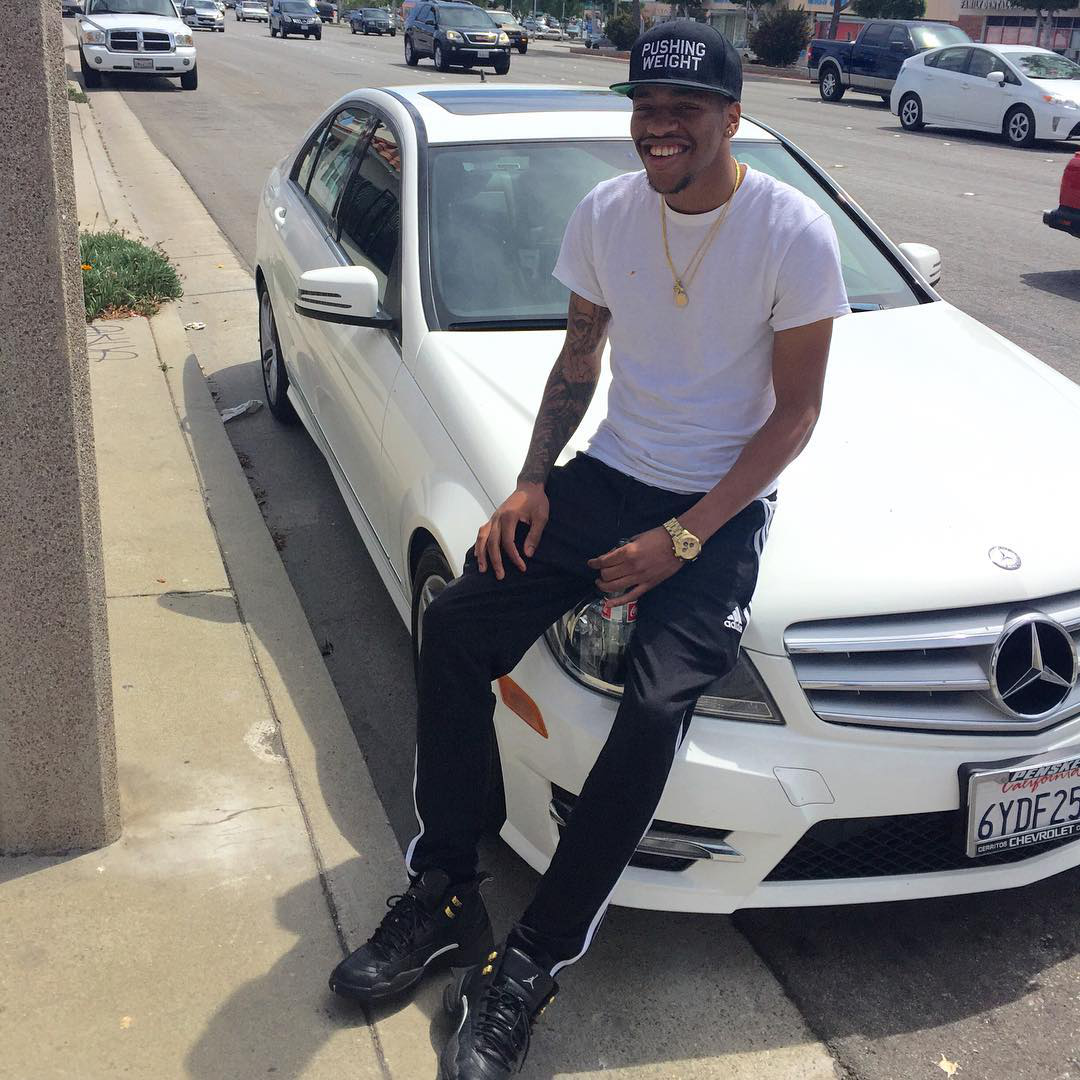

In [139]:
num = 5010
img_path = os.path.join("train", annotation[num][1])
#mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
img = Image.open(img_path).convert("RGB")
print('target', annotation[num, 4])
print('boxes', annotation[num][5:9])
img

In [134]:
# pick one image from the test set
img, _ = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to('cpu')])
    
prediction[0]

{'boxes': tensor([[  21.1634,  776.8896,  101.6154,  856.3831],
         [ 887.8901,  346.9011,  908.7220,  363.8595],
         [ 865.9109,  345.8053,  893.7623,  363.5903],
         [ 333.2028,  771.8491,  436.2597, 1052.6586],
         [ 424.1701,  669.1344,  643.7623, 1110.4377],
         [ 822.0300,  236.9328,  861.7619,  303.2376],
         [ 252.8672, 1062.0391,  333.1206, 1199.5183],
         [  34.2695,  795.5261,   84.6325,  848.5409],
         [ 375.5155,  935.1522,  433.4576, 1012.0579],
         [ 741.4457,  244.9660,  800.3897,  319.7540],
         [  31.8131,  818.9272,  101.8359,  895.4230],
         [  76.2328,  580.4299,  101.5335,  605.5570],
         [ 722.1967,  246.2009,  780.8817,  323.5978],
         [ 346.9026,  677.9308,  454.8055,  960.8369],
         [ 364.6725,  897.5674,  427.9630, 1020.0770],
         [ 621.8721,  390.3376,  662.9444,  436.5311],
         [  29.6233,  848.9912,  104.8389,  884.2318],
         [  71.4247,  385.5149,  138.0768,  405.0663],
 

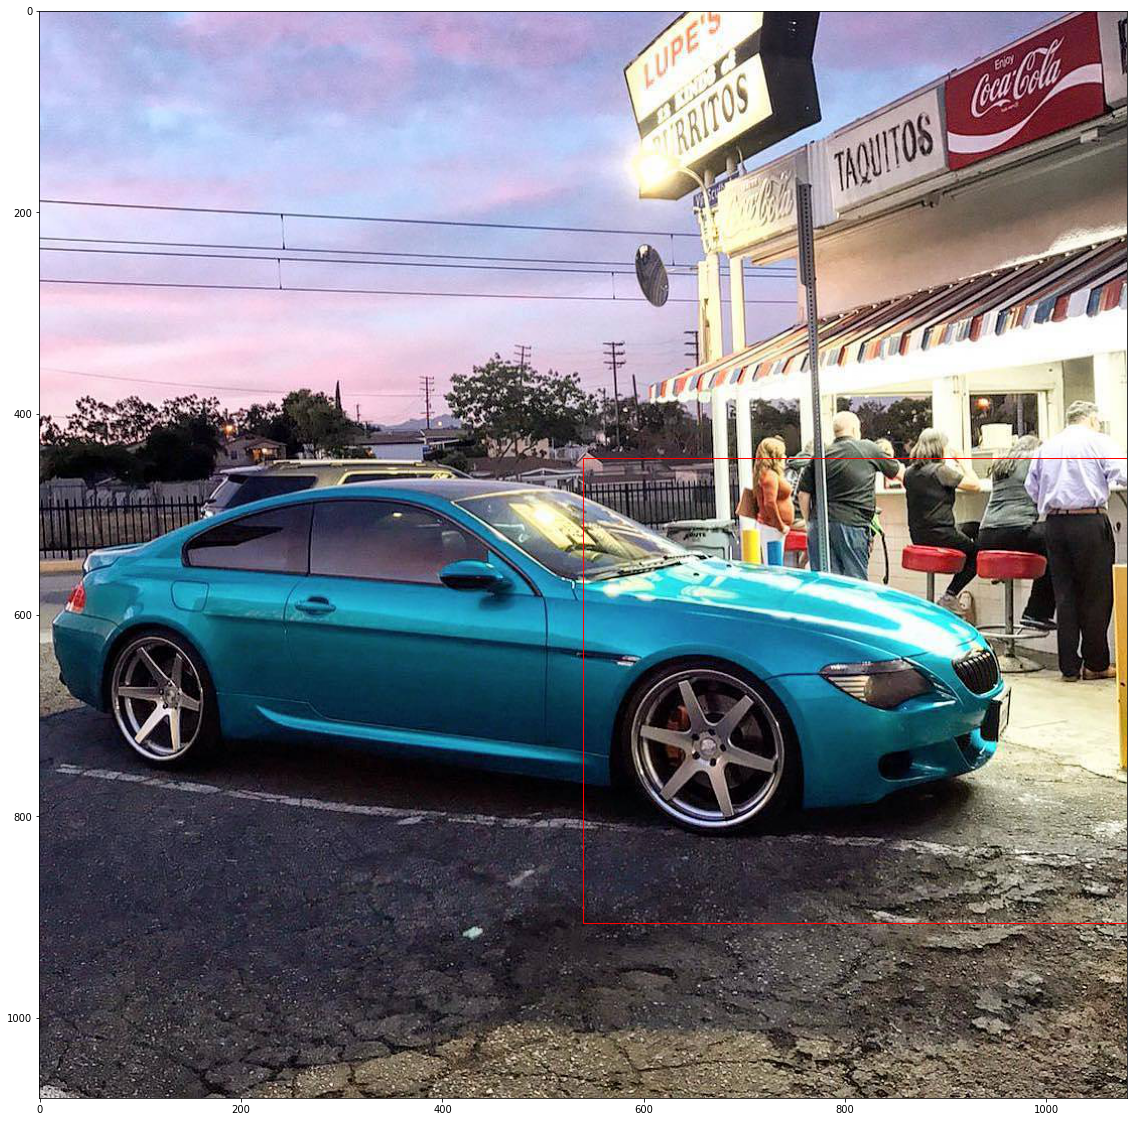

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
plt.imshow(img.permute(1, 2, 0))
plt.gca().add_patch(Rectangle((540,444),558, 462, linewidth=1,edgecolor='r',facecolor='none'))

### Save a model to avoid training

In [17]:
#torch.save(model.state_dict(), 'model_1')

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 5  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
model.load_state_dict(torch.load('model_1'))

<All keys matched successfully>

In [20]:
num_classes = 5
# use our dataset and defined transformations
i, f = 5000, 7000
dataset = DLCVDataset(annotation=annotation[:i], transforms=get_transform(train=True))
dataset_test = DLCVDataset(annotation=annotation[i:f], transforms=get_transform(train=False))

# split the dataset in train and test set

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


In [21]:
evaluate(model, data_loader_test, device)


creating index...
index created!
hello


/home/3040302/.conda/envs/vision2021/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Test:  [   0/2000]  eta: 0:27:41  model_time: 0.4061 (0.4061)  evaluator_time: 0.0059 (0.0059)  time: 0.8305  data: 0.3908  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
Test:  [ 100/2000]  eta: 0:02:07  model_time: 0.0390 (0.0456)  evaluator_time: 0.0018 (0.0026)  time: 0.0588  data: 0.0059  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hell

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
Test:  [1200/2000]  eta: 0:00:47  model_time: 0.0398 (0.0422)  evaluator_time: 0.0022 (0.0026)  time: 0.0575  data: 0.0052  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
h